In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import shap
import xgboost as xgb
from sklearn.metrics import r2_score as r2_score_function
from matplotlib.lines import Line2D
import joblib

In [2]:
data = pd.read_csv('DataTrainValidation.csv')
data['theta12'] = data['theta1'] + data['theta2']
data = data.drop(['theta1', 'theta2'], axis=1)
X = pd.concat([data.iloc[:, 1:-2], data.iloc[:, -1:]], axis=1)
Y = data.iloc[:,-2]
X

,Mean_Cu-O,Mean_Cu-N,Mean_O-Cu-O,Mean_N-Cu-N,theta12
0,577.365,529.933,312.619,287.445,191.481
1,573.684,526.929,275.663,245.595,192.903
2,574.144,532.502,289.075,301.632,190.301
3,583.671,519.973,335.416,289.010,192.494
4,566.869,496.398,299.624,270.938,194.407
...,...,...,...,...,...
103,583.319,503.472,304.435,362.135,183.080
104,592.000,496.050,310.579,350.796,182.800
105,629.034,519.737,424.327,329.601,190.150
106,628.584,506.082,435.644,301.641,193.540


**Determining the random state**

In [4]:
R2test = []
R2train = []
rmsetest = []
rmsetrain = []

start = 0
end = 2000
test_size = 0.1

for random_state in range(start, end + 1):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    model = GradientBoostingRegressor(random_state=random_state)
    model.fit(X_train, Y_train)
    
    Y_pred_test = model.predict(X_test) 
    Y_pred_train = model.predict(X_train) 
    
    R2_test = r2_score(Y_test, Y_pred_test)
    R2_train = r2_score(Y_train, Y_pred_train)
       
    rmse_test = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
    rmse_train = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
    
    R2test.append(R2_test)
    R2train.append(R2_train)
    rmsetest.append(rmse_test)
    rmsetrain.append(rmse_train)

    
minrmsetest = min(rmsetest)  
ind = rmsetest.index(minrmsetest)  
avg_rmse_train = np.mean(rmsetrain)
avg_rmse_test = np.mean(rmsetest)
avg_r2_train = np.mean(R2train)
avg_r2_test = np.mean(R2test)
print("Random state is = ", start+ind)
print("Best R2 train/test =  ", R2train[ind]," / ", R2test[ind])
print("Best RMSE train/test = ", rmsetrain[ind]," / ",rmsetest[ind])
print("Avg R2 train/test =  ", avg_r2_train," / ", avg_r2_test)
print("Avg RMSE train/test = ", avg_rmse_train," / ",avg_rmse_test)

Random state is =  29
Best R2 train/test =   0.9925328420335973  /  0.9581466971064018
Best RMSE train/test =  1.541912022731964  /  2.728304962441631
Avg R2 train/test =   0.9938683595320867  /  0.6832120330854617
Avg RMSE train/test =  1.3630603951864053  /  8.273448355062238


**Feature importance plot with all the data**

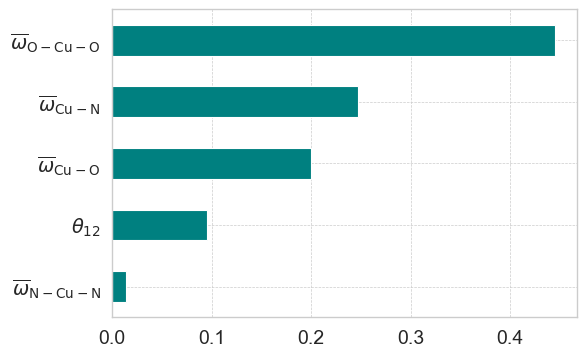

In [19]:
model = GradientBoostingRegressor(random_state=29)
model.fit(X, Y)

feature_names = X.columns
feature_importances = model.feature_importances_
importances = pd.Series(feature_importances, index=feature_names)

# Sort the features by importance
importances_sorted = importances.sort_values()

plt.figure(figsize=(6, 4))
plt.grid()
ax = importances_sorted.plot(kind='barh', color='teal')

# Define new labels
new_labels = [
    r'$\overline{\omega}_{\mathrm{N-Cu-N}}$',
    r'$\theta_{12}$',
    r'$\overline{\omega}_{\mathrm{Cu-O}}$',
    r'$\overline{\omega}_{\mathrm{Cu-N}}$',
    r'$\overline{\omega}_{\mathrm{O-Cu-O}}$'
]

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Apply new labels
ax.set_yticklabels(new_labels, fontsize=14, fontweight='bold')
plt.xticks(fontsize=14)

plt.rcParams['text.usetex'] = True

plt.savefig('gbr_feature.png', dpi=500, bbox_inches='tight')
plt.show()

**Defining errors and parity plots**

In [3]:
def rmse(y_true, y_predictions): 
    return round(np.sqrt(metrics.mean_squared_error(y_true, y_predictions)), 4)

def rmse_std(y_true, y_predictions): 
    return round(rmse(y_true, y_predictions) / np.std(y_true), 4)

def mae(y_true, y_predictions): 
    return round(metrics.mean_absolute_error(y_true, y_predictions), 4)

def r2(y_true, y_predictions): 
    return round(metrics.r2_score(y_true, y_predictions), 4)

def parity_plot(y_true, y_predictions, title, filename):
    plt.figure(figsize=(6, 6))
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.5)
    plt.xlim(40, 160)
    plt.ylim(40, 160)
    
    colorscheme = ['red' if abs(true - pred) > 5 else 'darkgreen' for true, pred in zip(y_true, y_predictions)]
    plt.scatter(y_true, y_predictions, c=colorscheme, alpha=0.9, linewidths=2, marker ="o")
    
    plt.plot([40, 160], [40, 160], 'k--', lw=2)
    plt.fill_between([40, 160], [50, 170], [30, 150], color='grey', alpha=0.1)
    plt.xlabel(r'$\Delta E_{DFT}^{\ddag}$', fontsize=16, fontweight='bold')
    plt.ylabel(r'$\Delta E_{ML}^{\ddag}$', fontsize=16, fontweight='bold')

    plt.xticks(fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')
    
    legend_elements = [Line2D([0], [0], color='darkgreen', marker='o', linestyle='', label='Prediction'),
                       Line2D([0], [0], color='black', linestyle='--', lw=2, label='Ideal')]
    plt.legend(handles=legend_elements, frameon=True)

    
    # plt.title(title)
    # plt.legend(["Prediction", "Ideal"], frameon=True)
    
    plt.savefig(filename, dpi=500, bbox_inches='tight')
    plt.show()


def parity_stats_side_by_side(y_left_true,Y_left_predictions,y_right_true,Y_right_predictions,title_left,title_right):
    
    rmse_left = rmse(y_left_true,Y_left_predictions)
    rmse_std_left = rmse_std(y_left_true,Y_left_predictions)
    mae_left = mae(y_left_true,Y_left_predictions)
    r2_left = r2(y_left_true,Y_left_predictions)
    
    rmse_right = rmse(y_right_true,Y_right_predictions)
    rmse_std_right = rmse_std(y_right_true,Y_right_predictions)
    mae_right = mae(y_right_true,Y_right_predictions)
    r2_right = r2(y_right_true,Y_right_predictions)
    
    stats_df = pd.DataFrame({'Error Metric' : ['RMSE', 'RMSE/std', 'MAE', 'R2'], 
                             title_left : [str(rmse_left) + " (kJ/mol)", rmse_std_left, str(mae_left) + " (kJ/mol)", r2_left],
                             title_right: [str(rmse_right) + " (kJ/mol)", rmse_std_right, str(mae_right) + " (kJ/mol)", r2_right],
                             'Note' : ['(0.0 for perfect prediction)', '(0.0 for perfect prediction)','(0.0 for perfect prediction)','(1.0 for perfect prediction)']})
    return stats_df



**GBR model fitting and prediction**

No. of Test complexes 11


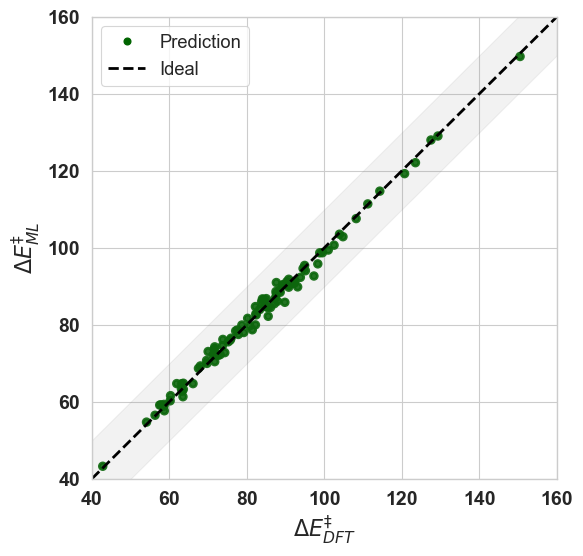

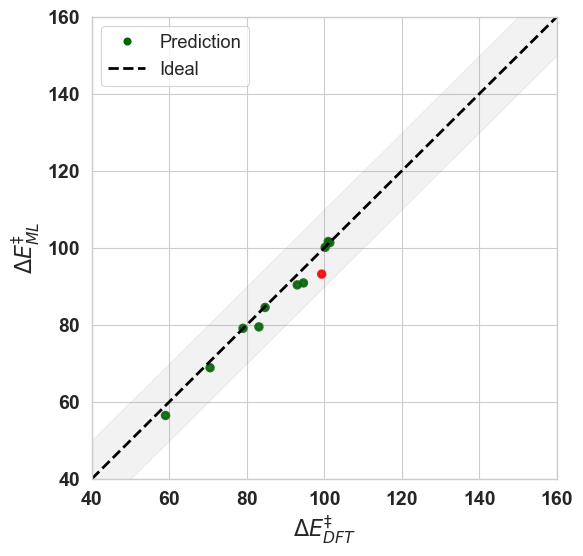

,Error Metric,Training Data,Test Data,Note
0,RMSE,1.5419 (kJ/mol),2.7283 (kJ/mol),(0.0 for perfect prediction)
1,RMSE/std,0.0864,0.2046,(0.0 for perfect prediction)
2,MAE,1.2306 (kJ/mol),1.9517 (kJ/mol),(0.0 for perfect prediction)
3,R2,0.9925,0.9581,(1.0 for perfect prediction)


In [4]:
random_state = 29
test_size = 0.1

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

# Initialize model with a random state
gbr_model = GradientBoostingRegressor(random_state=random_state)

# Fit model
gbr_model.fit(X_train, Y_train)

# Save the trained model to a file
joblib.dump(gbr_model, 'gbr_model.pkl')

# Predict
Train_predictions = gbr_model.predict(X_train)
Test_predictions = gbr_model.predict(X_test)

print('No. of Test complexes', len(X_test))
# Plot and save training data parity plot
parity_plot(Y_train, Train_predictions, "Training Data Parity Plot", "training_parity_plot_gbr.png")

# Plot and save test data parity plot
parity_plot(Y_test, Test_predictions, "Test Data Parity Plot", "test_parity_plot_gbr.png")

parity_stats_side_by_side(Y_train,Train_predictions,Y_test,Test_predictions,"Training Data","Test Data")  # print error metrics for training data

# print(X_test, Y_test, Test_predictions)
# print(Y_test-Test_predictions)

**Testing five random systems**

Catalyst: 7_och3_no2, DFT: 74.4, Predicted: 71.81058914350318, Difference: -2.5894108564968263
Catalyst: iminch32, DFT: 94.0, Predicted: 89.60240678326328, Difference: -4.397593216736723
Catalyst: 1C_7, DFT: 53.3, Predicted: 56.93751813238503, Difference: 3.6375181323850327
Catalyst: 2C_19, DFT: 79.7, Predicted: 74.91373101485962, Difference: -4.7862689851403815
Catalyst: DA2_th_th, DFT: 79.7, Predicted: 81.98766377202563, Difference: 2.287663772025624


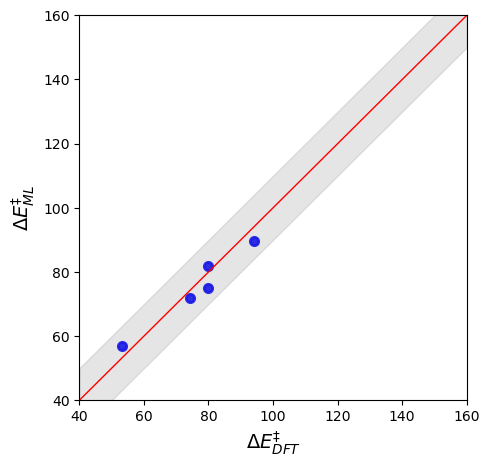

R2: 0.9224187339997588
MAE: 3.5396909925569178


In [32]:
df2 = pd.read_csv('DataTest.csv')
df2['theta12'] = df2['theta1'] + df2['theta2']
# Prepare the features for prediction
features_df2 = df2.drop([ 'Folder', 'Barrier', 'theta1', 'theta2'], axis=1)

# Make predictions
predictions_test12 = gbr_model.predict(features_df2)

# Calculate differences
differences = predictions_test12 - df2['Barrier']

# Print Folder, Actual, Predicted, and Difference
for folder, actual, predicted, difference in zip(df2['Folder'], df2['Barrier'], predictions_test12, differences):
    print(f"Catalyst: {folder}, DFT: {actual}, Predicted: {predicted}, Difference: {difference}")

# Plotting
plt.style.use('default')
plt.figure(figsize=(5, 5))
plt.scatter(df2['Barrier'], predictions_test12, color='blue', alpha=0.9, linewidths=2, marker ="o")
plt.plot([40, 160], [40, 160], color='red', linestyle='-', linewidth=1, markersize=12)
plt.xlim(40, 160)
plt.ylim(40, 160)
plt.fill_between([40, 160], [50, 170], [30, 150], color='grey', alpha=0.2)
plt.xlabel(r'$\Delta E_{DFT}^{\ddag}$', fontsize=14)
plt.ylabel(r'$\Delta E_{ML}^{\ddag}$', fontsize=14)
plt.show()

# Calculate R2 and MAE
r2 = r2_score(df2['Barrier'], predictions_test12)
mae = mean_absolute_error(df2['Barrier'], predictions_test12)

print('R2:', r2)
print('MAE:', mae)


**Level of Theory: B3LYP-D3/6-311+G***

   Mean_Cu-O  Mean_Cu-N  Mean_O-Cu-O  Mean_N-Cu-N  theta12
0    594.126    497.886      379.307      201.016   192.28
1    594.659    521.707      414.260      291.453   191.55
2    601.515    480.192      380.308      529.388   143.03
3    603.811    501.659      407.759      433.281   173.15
4    596.877    508.360      398.942      363.589   182.53
Catalyst: 7_och3_no2, DFT: 69.24, Predicted: 85.78407026979708, Difference: 16.54407026979709
Catalyst: iminch32, DFT: 90.34, Predicted: 89.73144076797328, Difference: -0.608559232026721
Catalyst: 1C_7, DFT: 45.69, Predicted: 61.82979590738295, Difference: 16.139795907382954
Catalyst: 2C_19, DFT: 72.95, Predicted: 76.10272041470975, Difference: 3.152720414709748
Catalyst: DA2_th_th, DFT: 70.99, Predicted: 84.14353243970902, Difference: 13.153532439709025


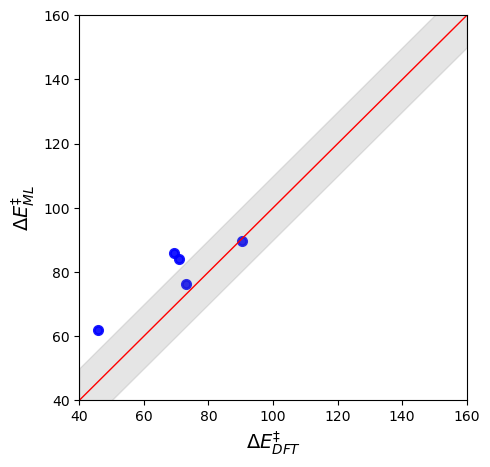

R2: 0.29295867920803875
MAE: 9.919735652725107


In [23]:
df3 = pd.read_csv('testset2_B3LYP-D3_6-311+g*.csv')
df3['theta12'] = df3['theta1'] + df3['theta2']
# Prepare the features for prediction
features_df3 = df3.drop(['Folder', 'Barrier', 'diamine', 'theta1', 'theta2'], axis=1)
print(features_df3)
# Make predictions
predictions_test3 = gbr_model.predict(features_df3)

# Calculate differences
differences3 = predictions_test3 - df3['Barrier']

# Print Folder, Actual, Predicted, and Difference
for folder, actual, predicted, difference in zip(df3['Folder'], df3['Barrier'], predictions_test3, differences3):
    print(f"Catalyst: {folder}, DFT: {actual}, Predicted: {predicted}, Difference: {difference}")

# Plotting
plt.style.use('default')
plt.figure(figsize=(5, 5))
plt.scatter(df3['Barrier'], predictions_test3, color='blue', alpha=0.9, linewidths=2, marker ="o")
plt.plot([40, 160], [40, 160], color='red', linestyle='-', linewidth=1, markersize=12)
plt.xlim(40, 160)
plt.ylim(40, 160)
plt.fill_between([40, 160], [50, 170], [30, 150], color='grey', alpha=0.2)
plt.xlabel(r'$\Delta E_{DFT}^{\ddag}$', fontsize=14)
plt.ylabel(r'$\Delta E_{ML}^{\ddag}$', fontsize=14)
plt.show()

# Calculate R2 and MAE
r2_test3 = r2_score(df3['Barrier'], predictions_test3)
mae_test3 = mean_absolute_error(df3['Barrier'], predictions_test3)

print('R2:', r2_test3)
print('MAE:', mae_test3)

**Level of theory: wB97X-D/6-31G***

Catalyst: 7_och3_no2, DFT: 86.82, Predicted: 69.6634796369918, Difference: -17.156520363008198
Catalyst: iminch32, DFT: 104.29, Predicted: 86.65323516047363, Difference: -17.63676483952638
Catalyst: 1C_7, DFT: 64.47, Predicted: 55.93993389984738, Difference: -8.530066100152617
Catalyst: 2C_19, DFT: 92.21, Predicted: 73.81568161446006, Difference: -18.394318385539933
Catalyst: DA2_th_th, DFT: 90.84, Predicted: 81.03300222520785, Difference: -9.806997774792151


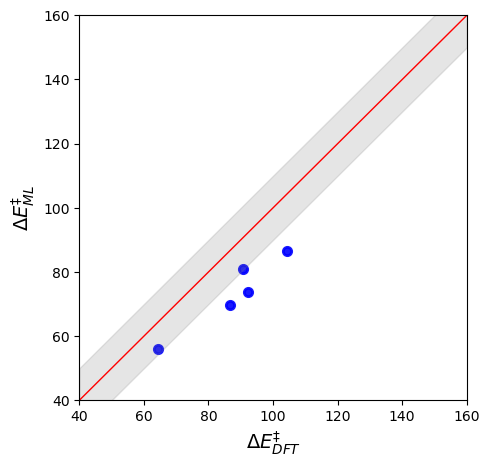

R2: -0.3155002591619904
MAE: 14.304933492603856


In [24]:
df4 = pd.read_csv('testset3_wB97X-D_631g*.csv')
df4['theta12'] = df4['theta1'] + df4['theta2']
# Prepare the features for prediction
features_df4 = df4.drop(['Folder', 'Barrier', 'diamine', 'theta1', 'theta2'], axis=1)

# Make predictions
predictions_test4 = gbr_model.predict(features_df4)

# Calculate differences
differences4 = predictions_test4 - df4['Barrier']

# Print Folder, Actual, Predicted, and Difference
for folder, actual, predicted, difference in zip(df4['Folder'], df4['Barrier'], predictions_test4, differences4):
    print(f"Catalyst: {folder}, DFT: {actual}, Predicted: {predicted}, Difference: {difference}")

# Plotting
plt.style.use('default')
plt.figure(figsize=(5, 5))
plt.scatter(df4['Barrier'], predictions_test4, color='blue', alpha=0.9, linewidths=2, marker ="o")
plt.plot([40, 160], [40, 160], color='red', linestyle='-', linewidth=1, markersize=12)
plt.xlim(40, 160)
plt.ylim(40, 160)
plt.fill_between([40, 160], [50, 170], [30, 150], color='grey', alpha=0.2)
plt.xlabel(r'$\Delta E_{DFT}^{\ddag}$', fontsize=14)
plt.ylabel(r'$\Delta E_{ML}^{\ddag}$', fontsize=14)
plt.show()

# Calculate R2 and MAE
r2_test4 = r2_score(df4['Barrier'], predictions_test4)
mae_test4 = mean_absolute_error(df4['Barrier'], predictions_test4)

print('R2:', r2_test4)
print('MAE:', mae_test4)

**Rescaled frequencies of B3LYP-D3/6-311+G***

Catalyst: 7_och3_no2, DFT: 69.24, Predicted: 83.40516100711878, Difference: 14.165161007118783
Catalyst: iminch32, DFT: 90.34, Predicted: 85.00915287026757, Difference: -5.330847129732433
Catalyst: 1C_7, DFT: 45.69, Predicted: 55.96114095812533, Difference: 10.27114095812533
Catalyst: 2C_19, DFT: 72.95, Predicted: 76.46699534936438, Difference: 3.516995349364379
Catalyst: DA2_th_th, DFT: 70.99, Predicted: 83.3387431663719, Difference: 12.348743166371904


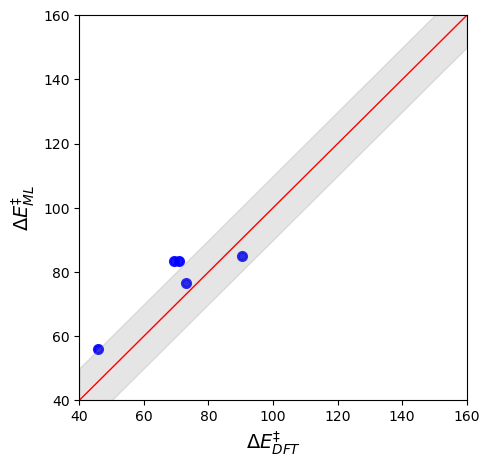

R2: 0.5078700815351498
MAE: 9.126577522142565


In [25]:
df5 = pd.read_csv('testset2_B3LYP-D3_6-311+g*_scaled.csv')
df5['theta12'] = df5['theta1'] + df5['theta2']
# Prepare the features for prediction
features_df5 = df5.drop(['Folder', 'Barrier', 'diamine', 'theta1', 'theta2'], axis=1)

# Make predictions
predictions_test5 = gbr_model.predict(features_df5)

# Calculate differences
differences5 = predictions_test5 - df5['Barrier']

# Print Folder, Actual, Predicted, and Difference
for folder, actual, predicted, difference in zip(df5['Folder'], df5['Barrier'], predictions_test5, differences5):
    print(f"Catalyst: {folder}, DFT: {actual}, Predicted: {predicted}, Difference: {difference}")

# Plotting
plt.style.use('default')
plt.figure(figsize=(5, 5))
plt.scatter(df5['Barrier'], predictions_test5, color='blue', alpha=0.9, linewidths=2, marker ="o")
plt.plot([40, 160], [40, 160], color='red', linestyle='-', linewidth=1, markersize=12)
plt.xlim(40, 160)
plt.ylim(40, 160)
plt.fill_between([40, 160], [50, 170], [30, 150], color='grey', alpha=0.2)
plt.xlabel(r'$\Delta E_{DFT}^{\ddag}$', fontsize=14)
plt.ylabel(r'$\Delta E_{ML}^{\ddag}$', fontsize=14)
plt.show()

# Calculate R2 and MAE
r2_test5 = r2_score(df5['Barrier'], predictions_test5)
mae_test5 = mean_absolute_error(df5['Barrier'], predictions_test5)

print('R2:', r2_test5)
print('MAE:', mae_test5)

**Rescaled frequencies of Level of theory: wB97X-D/6-31G***

Catalyst: 7_och3_no2, DFT: 86.82, Predicted: 66.88701224800435, Difference: -19.93298775199564
Catalyst: iminch32, DFT: 104.29, Predicted: 87.27823696042296, Difference: -17.011763039577048
Catalyst: 1C_7, DFT: 64.47, Predicted: 56.677643886115206, Difference: -7.792356113884793
Catalyst: 2C_19, DFT: 92.21, Predicted: 82.77431222355212, Difference: -9.435687776447878
Catalyst: DA2_th_th, DFT: 90.84, Predicted: 82.22196831934141, Difference: -8.61803168065859


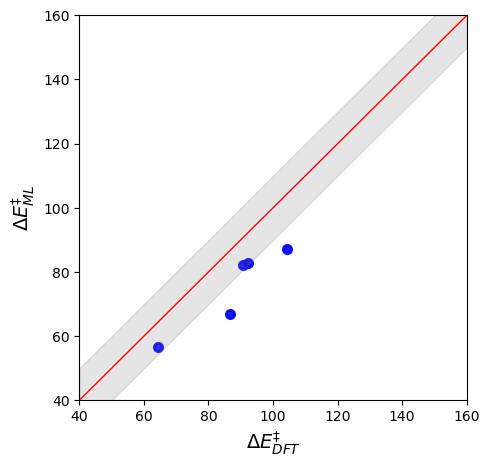

R2: -0.07674794946797259
MAE: 12.55816527251279


In [29]:
df6 = pd.read_csv('testset3_wB97X-D_631g*_scaled.csv')
df6['theta12'] = df6['theta1'] + df6['theta2']
# Prepare the features for prediction
features_df6 = df6.drop(['Folder', 'Barrier', 'diamine', 'theta1', 'theta2'], axis=1)

# Make predictions
predictions_test6 = gbr_model.predict(features_df6)

# Calculate differences
differences6 = predictions_test6 - df6['Barrier']

# Print Folder, Actual, Predicted, and Difference
for folder, actual, predicted, difference in zip(df6['Folder'], df6['Barrier'], predictions_test6, differences6):
    print(f"Catalyst: {folder}, DFT: {actual}, Predicted: {predicted}, Difference: {difference}")

# Plotting
plt.style.use('default')
plt.figure(figsize=(5, 5))
plt.scatter(df6['Barrier'], predictions_test6, color='blue', alpha=0.9, linewidths=2, marker ="o")
plt.plot([40, 160], [40, 160], color='red', linestyle='-', linewidth=1, markersize=12)
plt.xlim(40, 160)
plt.ylim(40, 160)
plt.fill_between([40, 160], [50, 170], [30, 150], color='grey', alpha=0.2)
plt.xlabel(r'$\Delta E_{DFT}^{\ddag}$', fontsize=14)
plt.ylabel(r'$\Delta E_{ML}^{\ddag}$', fontsize=14)
plt.show()

# Calculate R2 and MAE
r2_test6 = r2_score(df6['Barrier'], predictions_test6)
mae_test6 = mean_absolute_error(df6['Barrier'], predictions_test6)

print('R2:', r2_test6)
print('MAE:', mae_test6)

**Variation with train/test size** 

<Figure size 800x600 with 0 Axes>

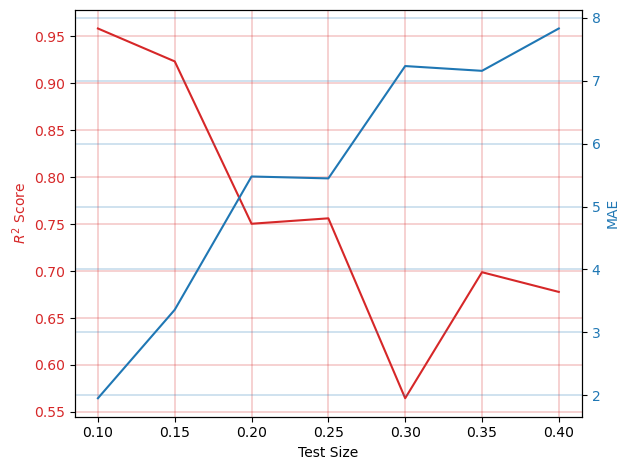

In [17]:
test_sizes = [0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1]
r2_scores = []
mae_scores = []

for test_size in test_sizes:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=29)
    gbr_model2 = GradientBoostingRegressor(random_state=29)
    gbr_model2.fit(X_train, Y_train)
    Test_predictions = gbr_model2.predict(X_test)

    r2 = r2_score(Y_test, Test_predictions)
    mae = mean_absolute_error(Y_test, Test_predictions)

    r2_scores.append(r2)
    mae_scores.append(mae)

# Plotting
plt.figure(figsize=(8, 6))
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Test Size')
ax1.set_ylabel('$R^2$ Score', color=color)
ax1.plot(test_sizes, r2_scores, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(color=color, linestyle='-', linewidth=0.3)


ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('MAE', color=color)  # we already handled the x-label with ax1
ax2.plot(test_sizes, mae_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(color=color, linestyle='-', linewidth=0.3)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.title('Model Performance vs Test Size')
plt.savefig('gbr_model_test_size.png', dpi=500, bbox_inches='tight')
plt.show()

**Further Testing for transferability**

Average R² score: 0.8163114322366433
R² scores for each fold: [0.8273314152565135, 0.8713350697720912, 0.7816473970385031, 0.7716455151993052, 0.829597763916803]
Average MAE: 5.69083336728161
MAE for each fold: [7.029170956951603, 3.0763648477775623, 5.8506976936449595, 7.185873052909699, 5.312060285124225]


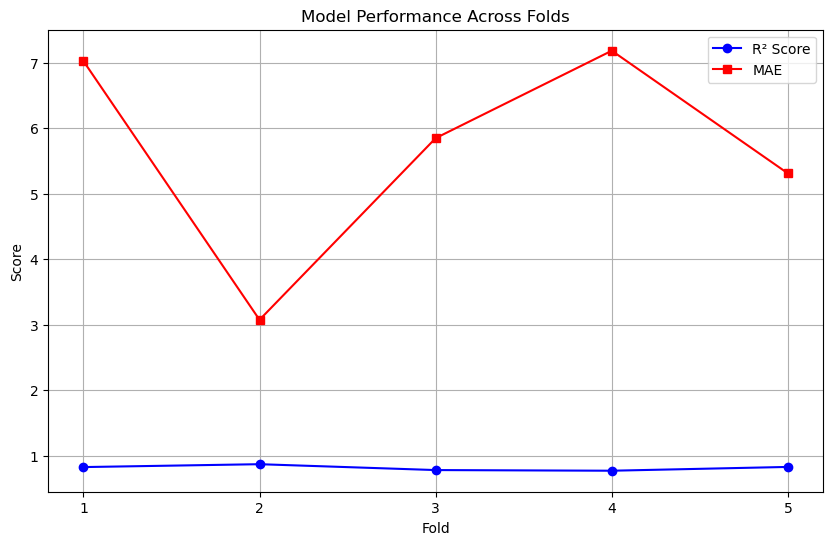

In [21]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1090)
r2_scores = []
mae_scores = []

gbr_model_kfold = GradientBoostingRegressor()
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    gbr_model_kfold.fit(X_train, y_train)

    # Make predictions
    predictions = gbr_model_kfold.predict(X_test)

    # Calculate and store R² and MAE
    r2_score = gbr_model_kfold.score(X_test, y_test)
    mae = mean_absolute_error(y_test, predictions)

    r2_scores.append(r2_score)
    mae_scores.append(mae)

# Calculate the average R² score and MAE
average_r2_score = np.mean(r2_scores)
average_mae = np.mean(mae_scores)

print("Average R² score:", average_r2_score)
print("R² scores for each fold:", r2_scores)
print("Average MAE:", average_mae)
print("MAE for each fold:", mae_scores)

plt.figure(figsize=(10, 6))
folds = range(1, 6)
# R² scores line
plt.plot(folds, r2_scores, marker='o', linestyle='-', color='b', label='R² Score')

# MAE line
plt.plot(folds, mae_scores, marker='s', linestyle='-', color='r', label='MAE')

plt.title('Model Performance Across Folds')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.xticks(folds)
plt.legend()
plt.grid(True)
plt.show()